In [26]:
import pandas as pd
from pandas import read_csv, datetime
from matplotlib import pyplot
import numpy as np

In [27]:
# read data
raw_data = read_csv('dataset/UAL_share.csv')
tweet_sentiment = pd.read_csv('dataset/sentiment_twitter.csv')

data = raw_data.drop(['date'], axis=1)
data.drop(data.index[[range(0,len(data.index)-len(tweet_sentiment.index))]], inplace=True)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1862 entries, 984 to 2845
Data columns (total 5 columns):
open      1862 non-null float64
high      1862 non-null float64
low       1862 non-null float64
close     1862 non-null float64
volume    1862 non-null int64
dtypes: float64(4), int64(1)
memory usage: 87.3 KB


,open,high,low,close,volume
984,12.99,13.11,12.53,12.80,8785900
985,12.87,14.10,12.87,13.91,23646300
986,13.74,13.99,13.13,13.27,15398700
987,13.20,13.95,13.20,13.55,10177000
988,13.56,13.86,13.13,13.33,5896400


In [28]:
#t-1 become input of t by shifting the volume
volume_2_predict = data['volume']
volume_2_predict = volume_2_predict.shift(periods=-1)
data['nextday_volume'] = volume_2_predict
data.rename(columns={'volume': 'today_volume'}, inplace=True)
#drop the last row because the NAN of shifting operator
data.drop(data.index[len(data)-1], inplace=True)
data.head()


,open,high,low,close,today_volume,nextday_volume
984,12.99,13.11,12.53,12.80,8785900,23646300.0
985,12.87,14.10,12.87,13.91,23646300,15398700.0
986,13.74,13.99,13.13,13.27,15398700,10177000.0
987,13.20,13.95,13.20,13.55,10177000,5896400.0
988,13.56,13.86,13.13,13.33,5896400,10168600.0


In [29]:
data_info = {}
#normalize data
mean_data = np.mean(data, axis=0) 
std_data = np.std(data, axis=0)
data_info['mean_data'] = mean_data
data_info['std_data'] = std_data
print mean_data
print std_data
data = data.apply(lambda x: (x-np.mean(x))/np.std(x))
data.info()
data.head() 

open              3.853887e+01
high              3.919567e+01
low               3.790066e+01
close             3.854502e+01
today_volume      5.908570e+06
nextday_volume    5.905212e+06
dtype: float64
open              1.773604e+01
high              1.793613e+01
low               1.753158e+01
close             1.774230e+01
today_volume      3.557585e+06
nextday_volume    3.557817e+06
dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1861 entries, 984 to 2844
Data columns (total 6 columns):
open              1861 non-null float64
high              1861 non-null float64
low               1861 non-null float64
close             1861 non-null float64
today_volume      1861 non-null float64
nextday_volume    1861 non-null float64
dtypes: float64(6)
memory usage: 101.8 KB


,open,high,low,close,today_volume,nextday_volume
984,-1.440506,-1.454364,-1.447141,-1.451053,0.808787,4.986510
985,-1.447272,-1.399168,-1.427747,-1.388491,4.985890,2.668347
986,-1.398219,-1.405301,-1.412917,-1.424563,2.667576,1.200677
987,-1.428665,-1.407531,-1.408924,-1.408782,1.199811,-0.002477
988,-1.408368,-1.412549,-1.412917,-1.421181,-0.003421,1.198316


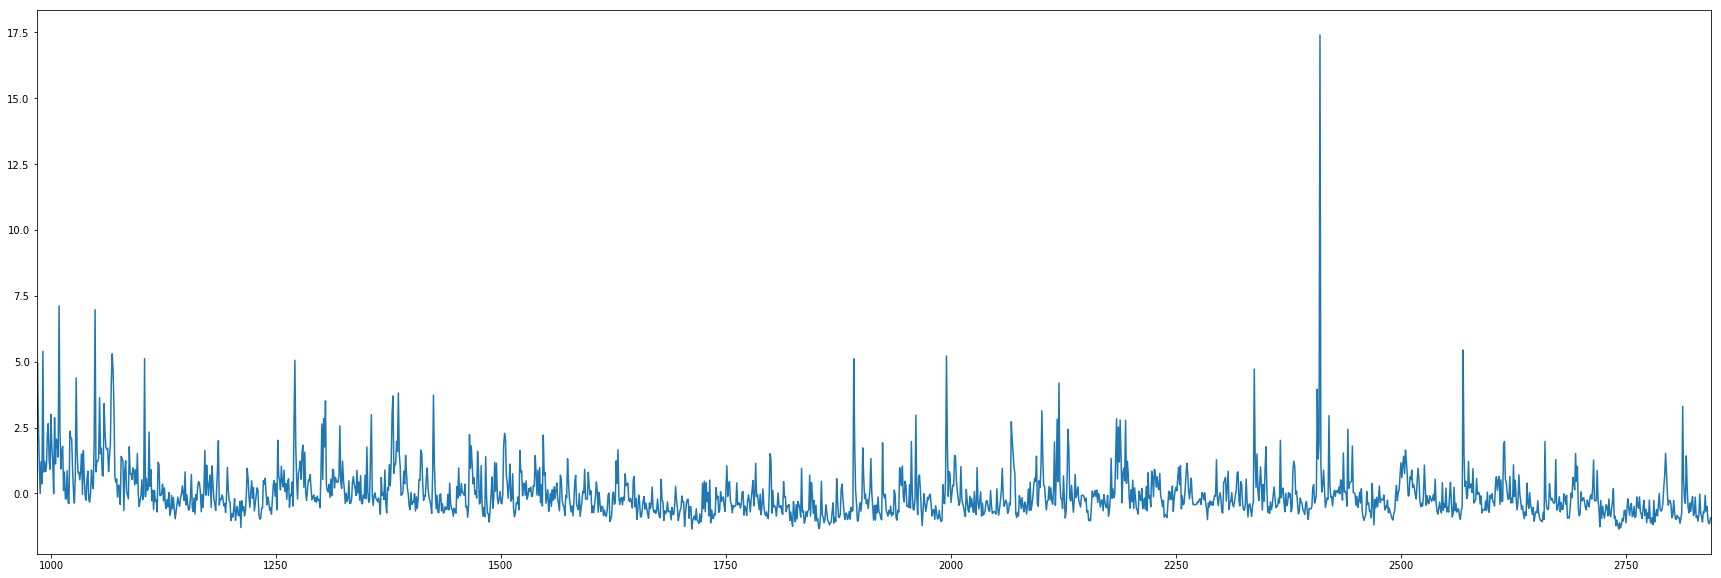

In [30]:
data['today_volume'].plot(figsize=(30, 10))
pyplot.show()

In [41]:
data_np = np.hsplit(data.as_matrix(), [0,-1])
X = data_np[1]
Y = data_np[-1]
max_Y = np.max(Y)
data_info['max_Y'] = max_Y
#scale Y to [-1;1]
Y /= max_Y
Y_base = np.array(Y)
# split into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
train_Y, test_Y = Y[0:train_size,:], Y[train_size:len(Y),:]
# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print "X train shape: ", train_X.shape
print "Y train shape: ", train_Y.shape
print "X test shape: ", test_X.shape
print "Y test shape: ", test_Y.shape


X train shape:  (1488, 1, 5)
Y train shape:  (1488, 1)
X test shape:  (373, 1, 5)
Y test shape:  (373, 1)


In [42]:
#model setting
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.models import model_from_json
from keras.layers.core import Dropout

batch_size = 1
pretrain = False

if not pretrain:
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(batch_size, train_X.shape[1], train_X.shape[2]), stateful=True, return_sequences=True))
    model.add(LSTM(4, batch_input_shape=(batch_size, 1, 1), stateful=True))
    model.add(Dense(1, activation='tanh'))
else:
    json_model = open('model.json')
    model = json_model.read()
    json_model.close()
    model = model_from_json(model)
    model.load_weights('model_weights.h5')
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [43]:
if not pretrain:

    #training
    model.fit(train_X, train_Y, epochs=100, batch_size=1, verbose=2)
    import h5py
    # save the model +
    info = model.to_json()
    with open("./model.json", "w") as json_file:
        json_file.write(info)
    model.save_weights("./model_weights.h5")

Epoch 1/100
20s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 2/100
21s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 3/100
21s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 4/100
22s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 5/100
21s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 6/100
21s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 7/100
21s - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 8/100
21s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 9/100
21s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 10/100
20s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 11/100
18s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 12/100
22s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 13/100
23s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 14/100
23s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 15/100
23s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 16/100
23s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 17/100
23s - loss: 0.0029 -

In [44]:
import math
from sklearn.metrics import mean_squared_error
plt = pyplot
plt.rcParams["figure.figsize"] = (30,50)

def invertScale(data, data_info):
    std_data = data_info['std_data']['nextday_volume']
    mean_data = data_info['mean_data']['nextday_volume']
    max_scale = data_info['max_Y']
    return data*max_scale*std_data + mean_data
def visual_result(model, train_X, train_Y, test_X, test_Y, Y_base, data_info):
    # make predictions
    trainPredict = model.predict(train_X, batch_size=1)
    testPredict = model.predict(test_X, batch_size=1)
    # invert predictions
    trainPredict = invertScale(trainPredict, data_info)
    trainY = invertScale(train_Y, data_info)
    testPredict = invertScale(testPredict, data_info)
    testY = invertScale(test_Y, data_info)
    
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    trainPredictPlot = np.empty(shape=(len(Y_base)))
    trainPredictPlot[:] = np.nan
    trainPredictPlot[0:len(trainPredict)] = trainPredict[:,0]
    # shift test predictions for plotting
    testPredictPlot = np.empty(shape=(len(Y_base)))
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict)-1+1:len(Y_base)] = testPredict[:,0]
    #baseline 
    baseline = invertScale(Y_base, data_info)

    return baseline, trainPredictPlot, testPredictPlot
   


Train Score: 186403.40 RMSE
Test Score: 133865.51 RMSE


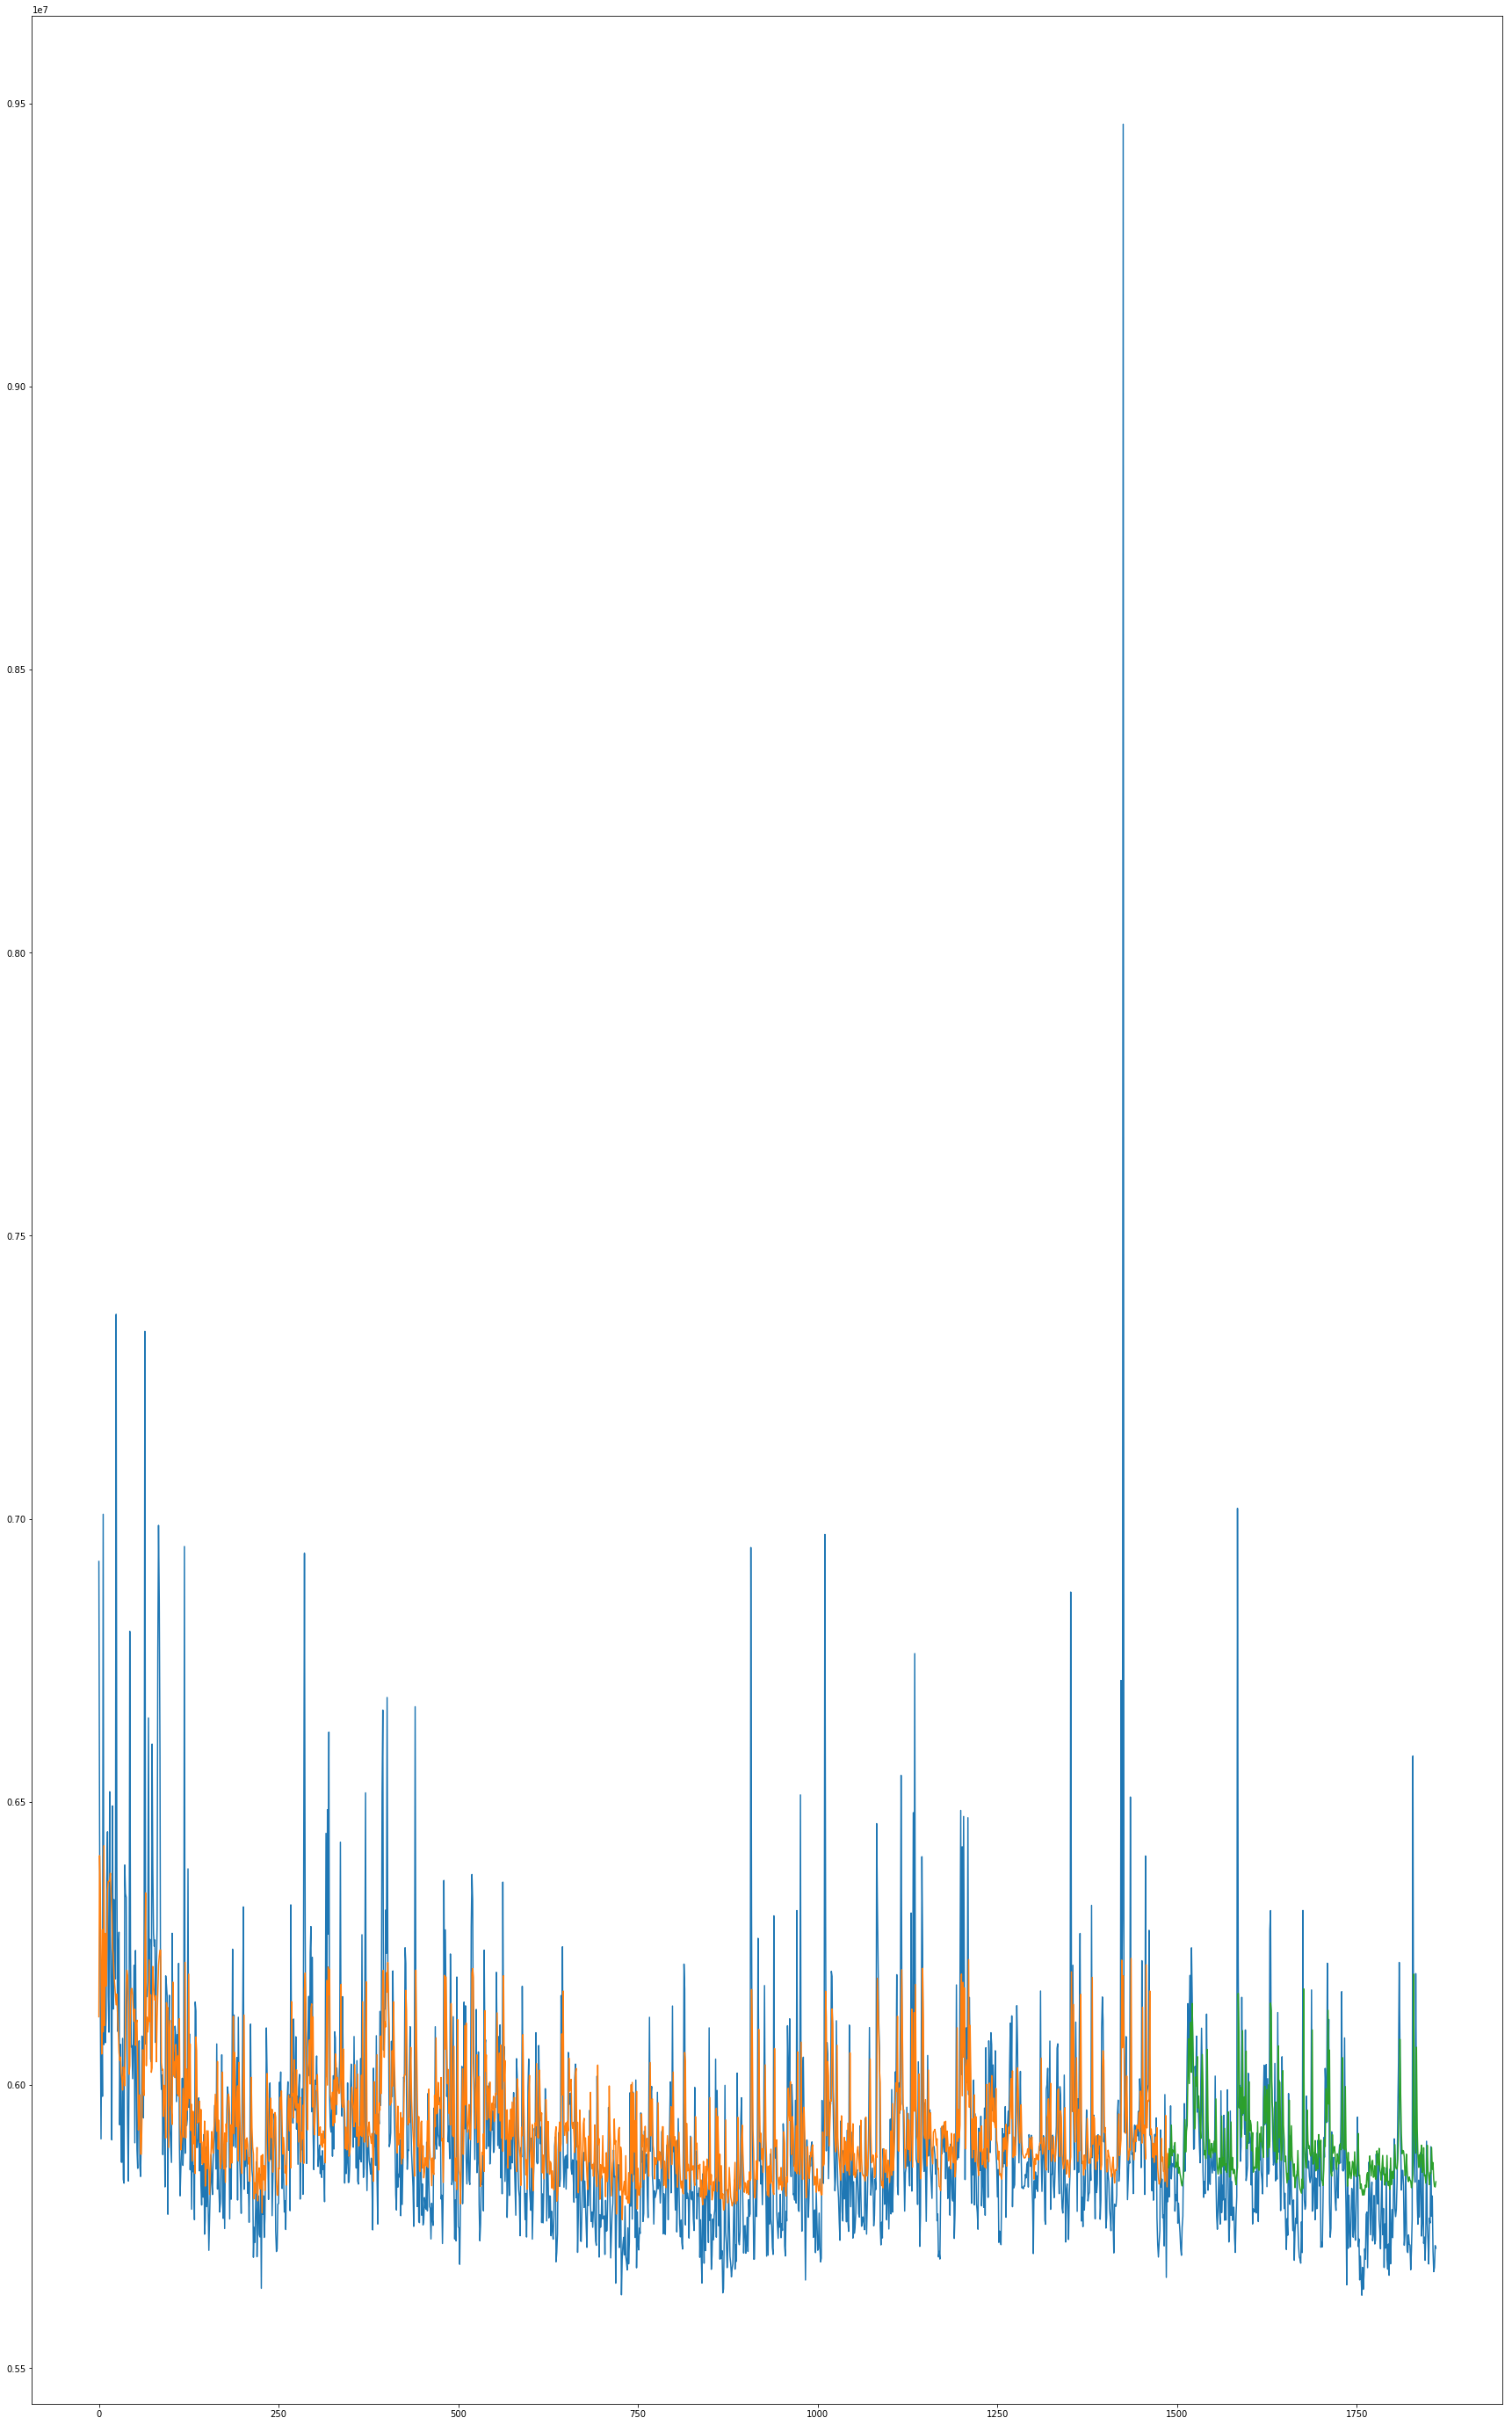

In [45]:
baseline, trainPredictPlot, testPredictPlot = visual_result(model, train_X, train_Y, test_X, test_Y, Y_base, data_info)
plt.plot(baseline)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [46]:
#-------------------------------------------------------------------------------------------------------------------------
"""
stock model with twitter
the sentiment of twitter already norm by std and mean
we collect tweet day by day from twitter, and using textblob framework to compute sentiment and the output is
    a score is a pair of (subject, polarity) after that we take polarity - subject. To compute sentiment of a day
    we take average sum of all the sentiment is already computed.
"""
# add std and mean of sentiment to data info 
data_info['std_data']['twitter_sentiment_std'] = 0.106175849012
data_info['mean_data']['twitter_sentiment_mean'] = -0.302494532549
# tweet_sentiment = pd.read_csv('sentiment_twitter.csv')
# drop the last row
tweet_sentiment.drop(tweet_sentiment.index[len(tweet_sentiment)-1], inplace=True)
sentiment = tweet_sentiment['sentiment'].as_matrix()
retweet = tweet_sentiment['retweet'].as_matrix() + 1

tweet = sentiment*retweet
tweet_Y_base = Y_base[len(Y_base)-len(tweet):,:]
# create data with sentiment 
X_tweet = np.hstack((X[len(X)-len(tweet):,:], tweet.reshape((len(tweet),1))))
Y_tweet = Y[len(Y)-len(tweet):,:]
size = int(len(X_tweet) * 0.8)
tweet_train_X, tweet_test_X = X_tweet[0:size,:], X_tweet[size:len(X_tweet),:]
tweet_train_Y, tweet_test_Y = Y_tweet[0:size,:], Y_tweet[size:len(X_tweet),:]

tweet_train_X = np.reshape(tweet_train_X, (tweet_train_X.shape[0], 1, tweet_train_X.shape[1]))
tweet_test_X = np.reshape(tweet_test_X, (tweet_test_X.shape[0], 1, tweet_test_X.shape[1]))

print "tweet_X train shape: ", tweet_train_X.shape
print "tweet_Y train shape: ", tweet_train_Y.shape
print "tweet_X test shape: ", tweet_test_X.shape
print "tweet_Y test shape: ", tweet_test_Y.shape


tweet_X train shape:  (1488, 1, 6)
tweet_Y train shape:  (1488, 1)
tweet_X test shape:  (372, 1, 6)
tweet_Y test shape:  (372, 1)


In [47]:
#define model
tweet_pretrain = False

if not tweet_pretrain:
    tweet_model = Sequential()
    tweet_model.add(LSTM(4, batch_input_shape=(batch_size, tweet_train_X.shape[1], tweet_train_X.shape[2]), stateful=True, return_sequences=True))
    tweet_model.add(LSTM(4, batch_input_shape=(batch_size, 1, 1), stateful=True))
    tweet_model.add(Dense(1, activation='tanh'))
else:
    json_model = open('tweet_model.json')
    tweet_model = json_model.read()
    json_model.close()
    tweet_model = model_from_json(model)
    tweet_model.load_weights('tweet_model_weights.h5')
tweet_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [48]:
if not tweet_pretrain:

    #training
    tweet_model.fit(tweet_train_X, tweet_train_Y, epochs=100, batch_size=1, verbose=2)
    import h5py
    # save the tweet_model +
    info = tweet_model.to_json()
    with open("./tweet_model.json", "w") as json_file:
        json_file.write(info)
    tweet_model.save_weights("./tweet_model_weights.h5")

Epoch 1/100
16s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 2/100
21s - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 3/100
22s - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 4/100
22s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 5/100
23s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 6/100
23s - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 7/100
22s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 8/100
24s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 9/100
23s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 10/100
23s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 11/100
23s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 12/100
23s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 13/100
23s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 14/100
23s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 15/100
23s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 16/100
23s - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 17/100
23s - loss: 0.0028 -

Train Score: 186498.72 RMSE
Test Score: 152077.91 RMSE


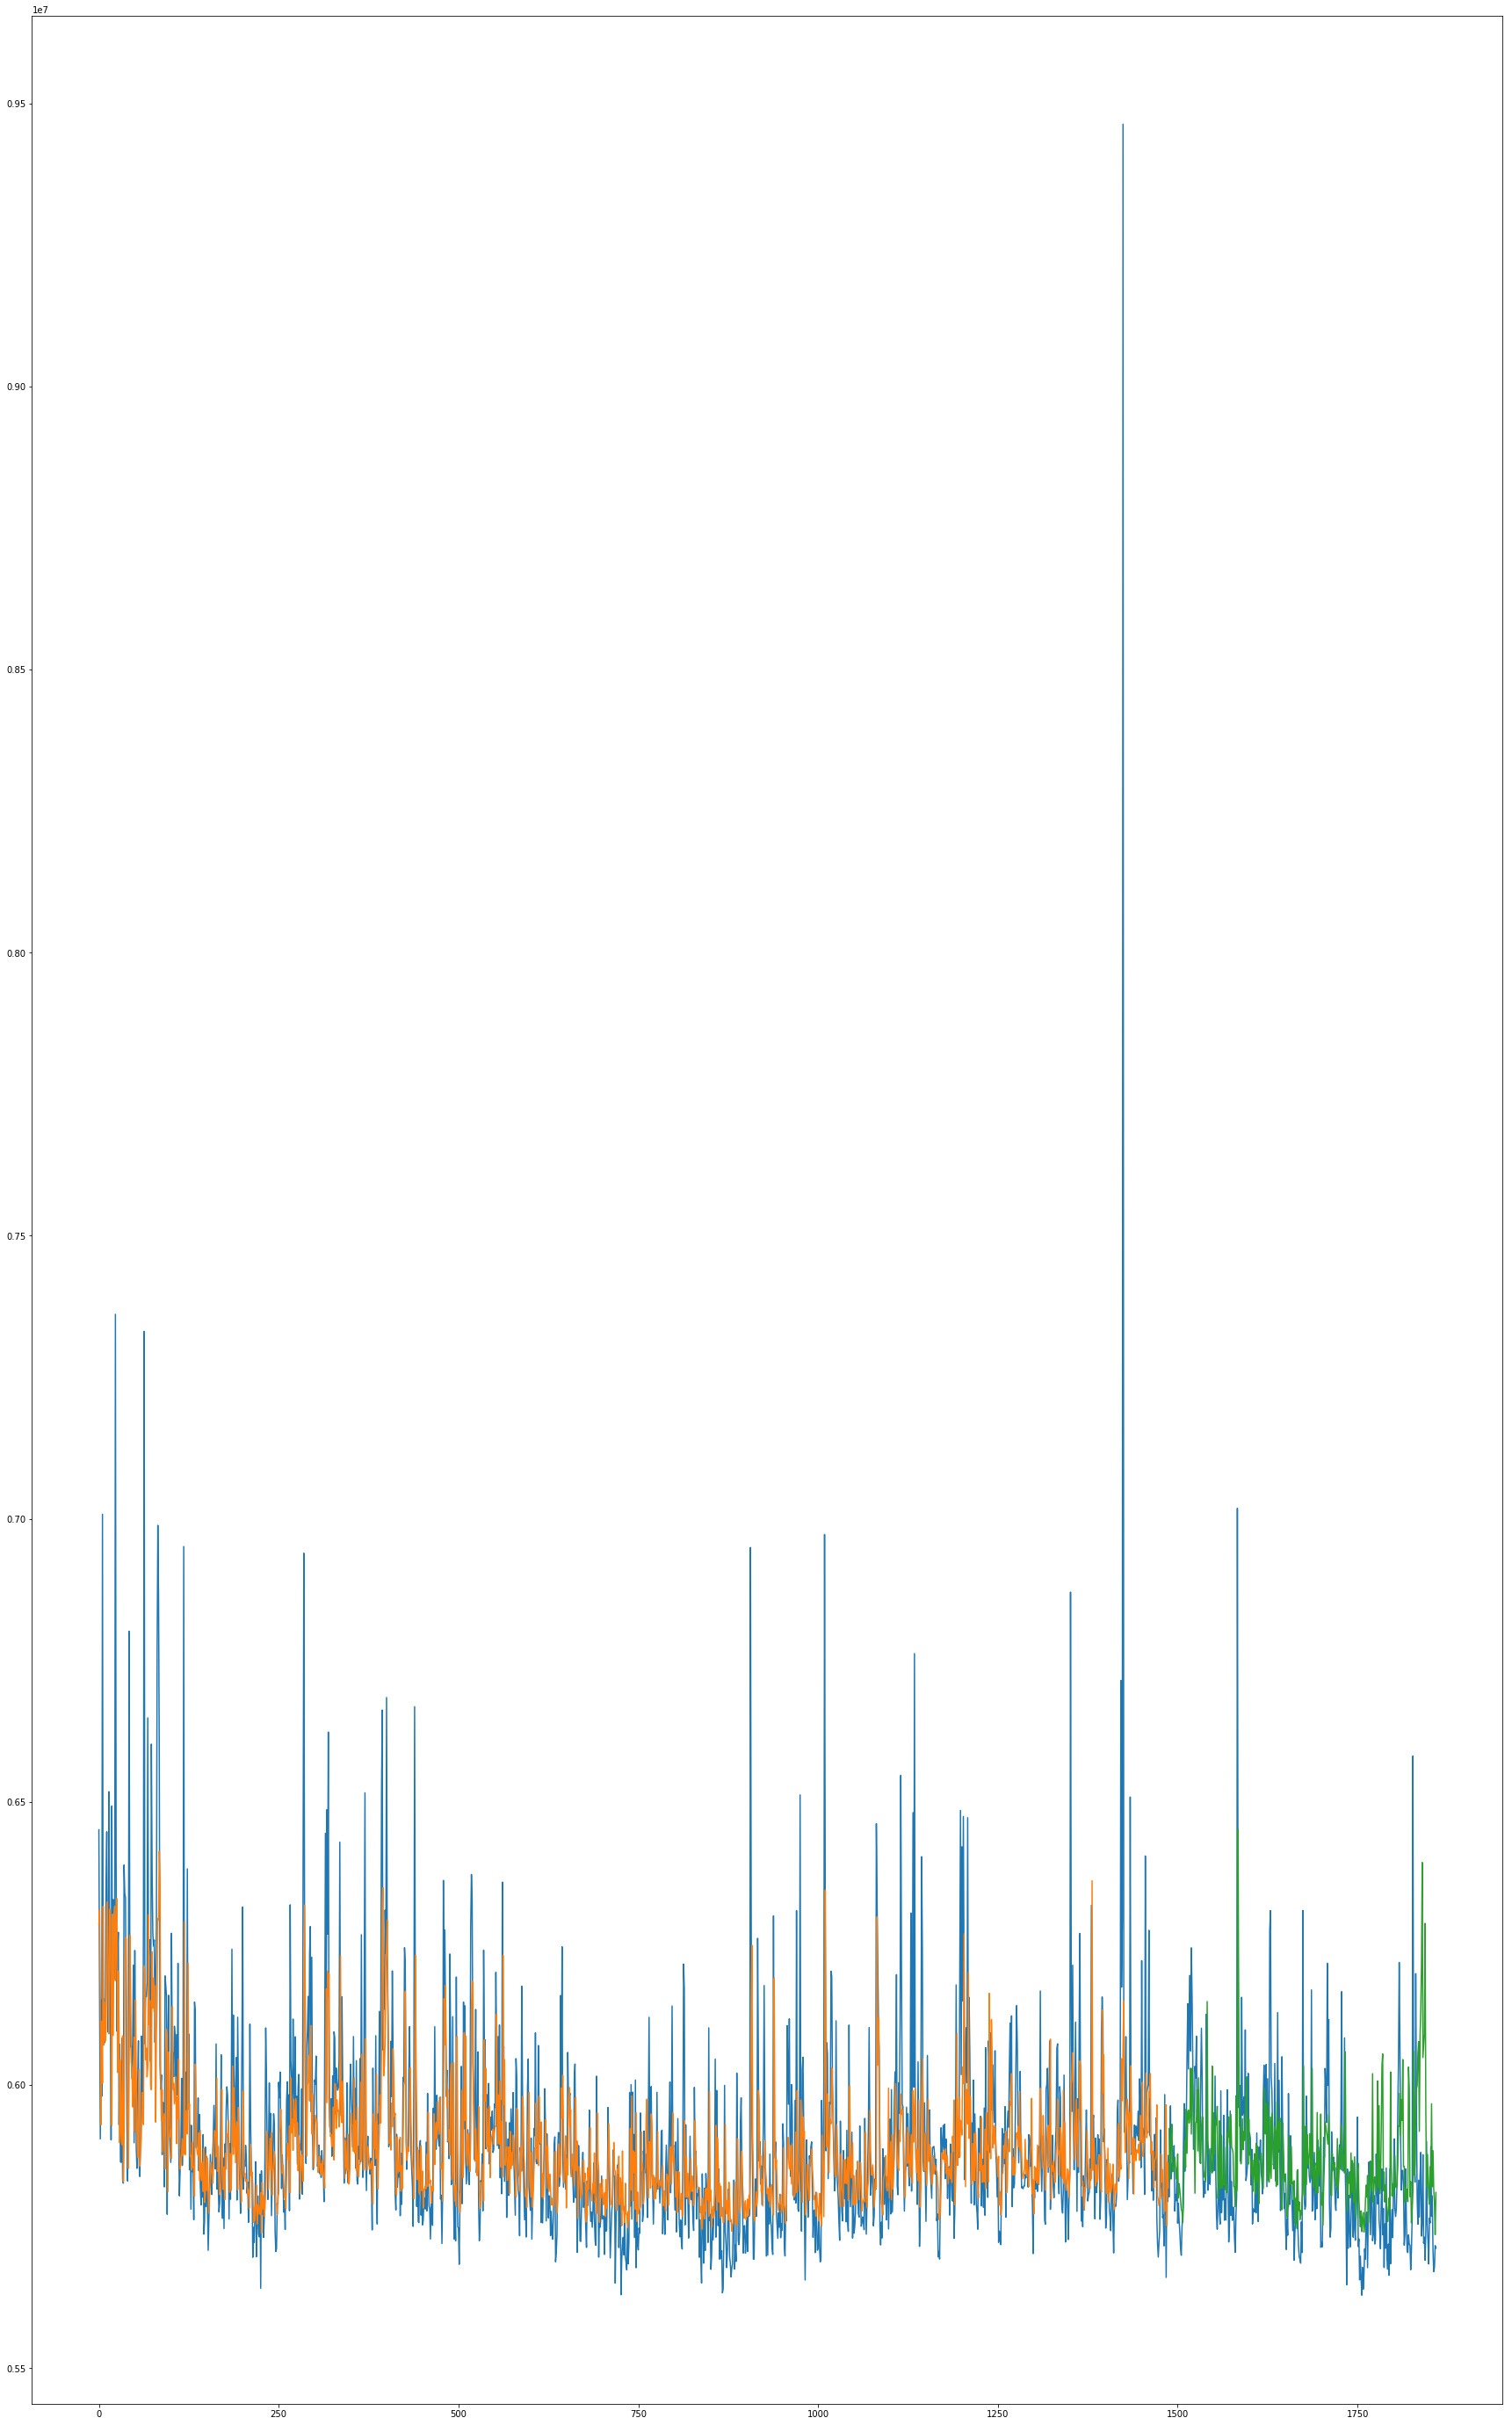

In [49]:
baseline, trainPredictPlot, testPredictPlot = visual_result(tweet_model, tweet_train_X, tweet_train_Y,\
                                                            tweet_test_X, tweet_test_Y, \
                                                            tweet_Y_base, data_info)

plt.plot(baseline)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (1, 1, 4)                 160       
_________________________________________________________________
lstm_10 (LSTM)               (1, 4)                    144       
_________________________________________________________________
dense_5 (Dense)              (1, 1)                    5         
Total params: 309
Trainable params: 309
Non-trainable params: 0
_________________________________________________________________
